# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4759552/11490434 [===========>..................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 13:06 - loss: 0.6937

  26/1875 [..............................] - ETA: 3s - loss: 0.5646   

  50/1875 [..............................] - ETA: 3s - loss: 0.4876

  84/1875 [>.............................] - ETA: 3s - loss: 0.4314

 117/1875 [>.............................] - ETA: 3s - loss: 0.3995

 144/1875 [=>............................] - ETA: 3s - loss: 0.3811

 173/1875 [=>............................] - ETA: 3s - loss: 0.3655

 206/1875 [==>...........................] - ETA: 2s - loss: 0.3513

 232/1875 [==>...........................] - ETA: 2s - loss: 0.3418

 261/1875 [===>..........................] - ETA: 2s - loss: 0.3325

 288/1875 [===>..........................] - ETA: 2s - loss: 0.3249

 323/1875 [====>.........................] - ETA: 2s - loss: 0.3162

 356/1875 [====>.........................] - ETA: 2s - loss: 0.3090

 385/1875 [=====>........................] - ETA: 2s - loss: 0.3033

 412/1875 [=====>........................] - ETA: 2s - loss: 0.2983

 443/1875 [======>.......................] - ETA: 2s - loss: 0.2931

 478/1875 [======>.......................] - ETA: 2s - loss: 0.2878

 511/1875 [=======>......................] - ETA: 2s - loss: 0.2831

 545/1875 [=======>......................] - ETA: 2s - loss: 0.2786

 579/1875 [========>.....................] - ETA: 2s - loss: 0.2745

 610/1875 [========>.....................] - ETA: 2s - loss: 0.2710

 636/1875 [=========>....................] - ETA: 2s - loss: 0.2682

 658/1875 [=========>....................] - ETA: 2s - loss: 0.2660

 679/1875 [=========>....................] - ETA: 2s - loss: 0.2639

 707/1875 [==========>...................] - ETA: 2s - loss: 0.2613

 732/1875 [==========>...................] - ETA: 2s - loss: 0.2590

 760/1875 [===========>..................] - ETA: 1s - loss: 0.2566

 784/1875 [===========>..................] - ETA: 1s - loss: 0.2546

 812/1875 [===========>..................] - ETA: 1s - loss: 0.2523

 836/1875 [============>.................] - ETA: 1s - loss: 0.2505

 862/1875 [============>.................] - ETA: 1s - loss: 0.2485

 883/1875 [=============>................] - ETA: 1s - loss: 0.2470

 904/1875 [=============>................] - ETA: 1s - loss: 0.2456

 928/1875 [=============>................] - ETA: 1s - loss: 0.2439

 957/1875 [==============>...............] - ETA: 1s - loss: 0.2420

 983/1875 [==============>...............] - ETA: 1s - loss: 0.2404

1010/1875 [===============>..............] - ETA: 1s - loss: 0.2387

1033/1875 [===============>..............] - ETA: 1s - loss: 0.2374

1059/1875 [===============>..............] - ETA: 1s - loss: 0.2359

1082/1875 [================>.............] - ETA: 1s - loss: 0.2346

1103/1875 [================>.............] - ETA: 1s - loss: 0.2334

1138/1875 [=================>............] - ETA: 1s - loss: 0.2315

1166/1875 [=================>............] - ETA: 1s - loss: 0.2301

1196/1875 [==================>...........] - ETA: 1s - loss: 0.2286

1229/1875 [==================>...........] - ETA: 1s - loss: 0.2270

1265/1875 [===================>..........] - ETA: 1s - loss: 0.2253

1296/1875 [===================>..........] - ETA: 1s - loss: 0.2239

1320/1875 [====================>.........] - ETA: 1s - loss: 0.2228

1348/1875 [====================>.........] - ETA: 0s - loss: 0.2216

1375/1875 [=====================>........] - ETA: 0s - loss: 0.2205

1397/1875 [=====================>........] - ETA: 0s - loss: 0.2196

1427/1875 [=====================>........] - ETA: 0s - loss: 0.2184

1453/1875 [======================>.......] - ETA: 0s - loss: 0.2173

1475/1875 [======================>.......] - ETA: 0s - loss: 0.2165

1501/1875 [=======================>......] - ETA: 0s - loss: 0.2155

1522/1875 [=======================>......] - ETA: 0s - loss: 0.2147

1547/1875 [=======================>......] - ETA: 0s - loss: 0.2138

1568/1875 [========================>.....] - ETA: 0s - loss: 0.2131

1593/1875 [========================>.....] - ETA: 0s - loss: 0.2122

1618/1875 [========================>.....] - ETA: 0s - loss: 0.2113

1640/1875 [=========================>....] - ETA: 0s - loss: 0.2106

1665/1875 [=========================>....] - ETA: 0s - loss: 0.2098

1686/1875 [=========================>....] - ETA: 0s - loss: 0.2091

1709/1875 [==========================>...] - ETA: 0s - loss: 0.2083

1734/1875 [==========================>...] - ETA: 0s - loss: 0.2075

1761/1875 [===========================>..] - ETA: 0s - loss: 0.2067

1787/1875 [===========================>..] - ETA: 0s - loss: 0.2059

1813/1875 [============================>.] - ETA: 0s - loss: 0.2051

1836/1875 [============================>.] - ETA: 0s - loss: 0.2044

1861/1875 [============================>.] - ETA: 0s - loss: 0.2037

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2033


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1037

  25/1875 [..............................] - ETA: 3s - loss: 0.1088

  46/1875 [..............................] - ETA: 4s - loss: 0.1092

  74/1875 [>.............................] - ETA: 3s - loss: 0.1093

  98/1875 [>.............................] - ETA: 3s - loss: 0.1092

 123/1875 [>.............................] - ETA: 3s - loss: 0.1091

 150/1875 [=>............................] - ETA: 3s - loss: 0.1089

 176/1875 [=>............................] - ETA: 3s - loss: 0.1088

 203/1875 [==>...........................] - ETA: 3s - loss: 0.1087

 230/1875 [==>...........................] - ETA: 3s - loss: 0.1086

 258/1875 [===>..........................] - ETA: 3s - loss: 0.1086

 282/1875 [===>..........................] - ETA: 3s - loss: 0.1085

 309/1875 [===>..........................] - ETA: 3s - loss: 0.1084

 333/1875 [====>.........................] - ETA: 3s - loss: 0.1083

 358/1875 [====>.........................] - ETA: 3s - loss: 0.1082

 383/1875 [=====>........................] - ETA: 3s - loss: 0.1081

 401/1875 [=====>........................] - ETA: 3s - loss: 0.1081

 421/1875 [=====>........................] - ETA: 3s - loss: 0.1080

 446/1875 [======>.......................] - ETA: 2s - loss: 0.1079

 473/1875 [======>.......................] - ETA: 2s - loss: 0.1079

 503/1875 [=======>......................] - ETA: 2s - loss: 0.1078

 526/1875 [=======>......................] - ETA: 2s - loss: 0.1077

 541/1875 [=======>......................] - ETA: 2s - loss: 0.1076

 564/1875 [========>.....................] - ETA: 2s - loss: 0.1076

 588/1875 [========>.....................] - ETA: 2s - loss: 0.1075

 612/1875 [========>.....................] - ETA: 2s - loss: 0.1074

 633/1875 [=========>....................] - ETA: 2s - loss: 0.1074

 659/1875 [=========>....................] - ETA: 2s - loss: 0.1073

 686/1875 [=========>....................] - ETA: 2s - loss: 0.1072

 713/1875 [==========>...................] - ETA: 2s - loss: 0.1072

 741/1875 [==========>...................] - ETA: 2s - loss: 0.1071

 770/1875 [===========>..................] - ETA: 2s - loss: 0.1070

 797/1875 [===========>..................] - ETA: 2s - loss: 0.1070

 825/1875 [============>.................] - ETA: 2s - loss: 0.1069

 854/1875 [============>.................] - ETA: 2s - loss: 0.1068

 883/1875 [=============>................] - ETA: 2s - loss: 0.1068

 911/1875 [=============>................] - ETA: 1s - loss: 0.1067

 939/1875 [==============>...............] - ETA: 1s - loss: 0.1066

 966/1875 [==============>...............] - ETA: 1s - loss: 0.1066

 994/1875 [==============>...............] - ETA: 1s - loss: 0.1065

1017/1875 [===============>..............] - ETA: 1s - loss: 0.1065

1042/1875 [===============>..............] - ETA: 1s - loss: 0.1064

1070/1875 [================>.............] - ETA: 1s - loss: 0.1064

1098/1875 [================>.............] - ETA: 1s - loss: 0.1063

1127/1875 [=================>............] - ETA: 1s - loss: 0.1062

1156/1875 [=================>............] - ETA: 1s - loss: 0.1062

1185/1875 [=================>............] - ETA: 1s - loss: 0.1061

1213/1875 [==================>...........] - ETA: 1s - loss: 0.1061

1243/1875 [==================>...........] - ETA: 1s - loss: 0.1060

1263/1875 [===================>..........] - ETA: 1s - loss: 0.1060

1287/1875 [===================>..........] - ETA: 1s - loss: 0.1059

1312/1875 [===================>..........] - ETA: 1s - loss: 0.1059

1337/1875 [====================>.........] - ETA: 1s - loss: 0.1058

1361/1875 [====================>.........] - ETA: 1s - loss: 0.1058

1386/1875 [=====================>........] - ETA: 0s - loss: 0.1057

1408/1875 [=====================>........] - ETA: 0s - loss: 0.1057

1435/1875 [=====================>........] - ETA: 0s - loss: 0.1056

1461/1875 [======================>.......] - ETA: 0s - loss: 0.1056

1488/1875 [======================>.......] - ETA: 0s - loss: 0.1055

1510/1875 [=======================>......] - ETA: 0s - loss: 0.1055

1540/1875 [=======================>......] - ETA: 0s - loss: 0.1054

1559/1875 [=======================>......] - ETA: 0s - loss: 0.1054

1585/1875 [========================>.....] - ETA: 0s - loss: 0.1054

1613/1875 [========================>.....] - ETA: 0s - loss: 0.1053

1640/1875 [=========================>....] - ETA: 0s - loss: 0.1053

1666/1875 [=========================>....] - ETA: 0s - loss: 0.1052

1692/1875 [==========================>...] - ETA: 0s - loss: 0.1052

1720/1875 [==========================>...] - ETA: 0s - loss: 0.1051

1745/1875 [==========================>...] - ETA: 0s - loss: 0.1051

1771/1875 [===========================>..] - ETA: 0s - loss: 0.1051

1797/1875 [===========================>..] - ETA: 0s - loss: 0.1050

1824/1875 [============================>.] - ETA: 0s - loss: 0.1050

1851/1875 [============================>.] - ETA: 0s - loss: 0.1049

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1049


Epoch 3/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0947

  29/1875 [..............................] - ETA: 3s - loss: 0.0974

  52/1875 [..............................] - ETA: 3s - loss: 0.0976

  80/1875 [>.............................] - ETA: 3s - loss: 0.0977

 105/1875 [>.............................] - ETA: 3s - loss: 0.0976

 131/1875 [=>............................] - ETA: 3s - loss: 0.0976

 155/1875 [=>............................] - ETA: 3s - loss: 0.0976

 181/1875 [=>............................] - ETA: 3s - loss: 0.0975

 207/1875 [==>...........................] - ETA: 3s - loss: 0.0975

 235/1875 [==>...........................] - ETA: 3s - loss: 0.0975

 263/1875 [===>..........................] - ETA: 3s - loss: 0.0975

 289/1875 [===>..........................] - ETA: 3s - loss: 0.0975

 316/1875 [====>.........................] - ETA: 3s - loss: 0.0976

 343/1875 [====>.........................] - ETA: 2s - loss: 0.0976

 370/1875 [====>.........................] - ETA: 2s - loss: 0.0976

 398/1875 [=====>........................] - ETA: 2s - loss: 0.0976

 416/1875 [=====>........................] - ETA: 2s - loss: 0.0976

 437/1875 [=====>........................] - ETA: 2s - loss: 0.0976

 466/1875 [======>.......................] - ETA: 2s - loss: 0.0976

 493/1875 [======>.......................] - ETA: 2s - loss: 0.0976

 516/1875 [=======>......................] - ETA: 2s - loss: 0.0976

 539/1875 [=======>......................] - ETA: 2s - loss: 0.0976

 562/1875 [=======>......................] - ETA: 2s - loss: 0.0976

 588/1875 [========>.....................] - ETA: 2s - loss: 0.0975

 616/1875 [========>.....................] - ETA: 2s - loss: 0.0975

 643/1875 [=========>....................] - ETA: 2s - loss: 0.0975

 664/1875 [=========>....................] - ETA: 2s - loss: 0.0975

 689/1875 [==========>...................] - ETA: 2s - loss: 0.0975

 718/1875 [==========>...................] - ETA: 2s - loss: 0.0975

 748/1875 [==========>...................] - ETA: 2s - loss: 0.0975

 777/1875 [===========>..................] - ETA: 2s - loss: 0.0975

 802/1875 [===========>..................] - ETA: 2s - loss: 0.0975

 827/1875 [============>.................] - ETA: 2s - loss: 0.0975

 857/1875 [============>.................] - ETA: 2s - loss: 0.0975

 875/1875 [=============>................] - ETA: 1s - loss: 0.0975

 902/1875 [=============>................] - ETA: 1s - loss: 0.0975

 930/1875 [=============>................] - ETA: 1s - loss: 0.0975

 956/1875 [==============>...............] - ETA: 1s - loss: 0.0975

 982/1875 [==============>...............] - ETA: 1s - loss: 0.0975

1006/1875 [===============>..............] - ETA: 1s - loss: 0.0975

1026/1875 [===============>..............] - ETA: 1s - loss: 0.0975

1052/1875 [===============>..............] - ETA: 1s - loss: 0.0974

1077/1875 [================>.............] - ETA: 1s - loss: 0.0974

1105/1875 [================>.............] - ETA: 1s - loss: 0.0974

1130/1875 [=================>............] - ETA: 1s - loss: 0.0974

1157/1875 [=================>............] - ETA: 1s - loss: 0.0974

1183/1875 [=================>............] - ETA: 1s - loss: 0.0974

1206/1875 [==================>...........] - ETA: 1s - loss: 0.0974

1236/1875 [==================>...........] - ETA: 1s - loss: 0.0974

1256/1875 [===================>..........] - ETA: 1s - loss: 0.0974

1277/1875 [===================>..........] - ETA: 1s - loss: 0.0974

1303/1875 [===================>..........] - ETA: 1s - loss: 0.0974

1329/1875 [====================>.........] - ETA: 1s - loss: 0.0974

1355/1875 [====================>.........] - ETA: 1s - loss: 0.0974

1387/1875 [=====================>........] - ETA: 0s - loss: 0.0974

1410/1875 [=====================>........] - ETA: 0s - loss: 0.0973

1437/1875 [=====================>........] - ETA: 0s - loss: 0.0973

1469/1875 [======================>.......] - ETA: 0s - loss: 0.0973

1499/1875 [======================>.......] - ETA: 0s - loss: 0.0973

1526/1875 [=======================>......] - ETA: 0s - loss: 0.0973

1555/1875 [=======================>......] - ETA: 0s - loss: 0.0973

1589/1875 [========================>.....] - ETA: 0s - loss: 0.0973

1615/1875 [========================>.....] - ETA: 0s - loss: 0.0973

1640/1875 [=========================>....] - ETA: 0s - loss: 0.0973

1668/1875 [=========================>....] - ETA: 0s - loss: 0.0973

1702/1875 [==========================>...] - ETA: 0s - loss: 0.0973

1733/1875 [==========================>...] - ETA: 0s - loss: 0.0973

1762/1875 [===========================>..] - ETA: 0s - loss: 0.0972

1788/1875 [===========================>..] - ETA: 0s - loss: 0.0972

1817/1875 [============================>.] - ETA: 0s - loss: 0.0972

1846/1875 [============================>.] - ETA: 0s - loss: 0.0972

1875/1875 [==============================] - ETA: 0s - loss: 0.0972

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0972


Epoch 4/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0941

  33/1875 [..............................] - ETA: 2s - loss: 0.0967

  64/1875 [>.............................] - ETA: 2s - loss: 0.0965

  94/1875 [>.............................] - ETA: 2s - loss: 0.0964

 123/1875 [>.............................] - ETA: 2s - loss: 0.0963

 154/1875 [=>............................] - ETA: 2s - loss: 0.0963

 185/1875 [=>............................] - ETA: 2s - loss: 0.0963

 217/1875 [==>...........................] - ETA: 2s - loss: 0.0963

 243/1875 [==>...........................] - ETA: 2s - loss: 0.0963

 268/1875 [===>..........................] - ETA: 2s - loss: 0.0963

 297/1875 [===>..........................] - ETA: 2s - loss: 0.0963

 331/1875 [====>.........................] - ETA: 2s - loss: 0.0963

 366/1875 [====>.........................] - ETA: 2s - loss: 0.0963

 401/1875 [=====>........................] - ETA: 2s - loss: 0.0963

 430/1875 [=====>........................] - ETA: 2s - loss: 0.0963

 463/1875 [======>.......................] - ETA: 2s - loss: 0.0963

 496/1875 [======>.......................] - ETA: 2s - loss: 0.0962

 524/1875 [=======>......................] - ETA: 2s - loss: 0.0962

 558/1875 [=======>......................] - ETA: 2s - loss: 0.0962

 593/1875 [========>.....................] - ETA: 2s - loss: 0.0962

 623/1875 [========>.....................] - ETA: 2s - loss: 0.0962

 657/1875 [=========>....................] - ETA: 1s - loss: 0.0962

 685/1875 [=========>....................] - ETA: 1s - loss: 0.0962

 713/1875 [==========>...................] - ETA: 1s - loss: 0.0962

 744/1875 [==========>...................] - ETA: 1s - loss: 0.0962

 780/1875 [===========>..................] - ETA: 1s - loss: 0.0961

 815/1875 [============>.................] - ETA: 1s - loss: 0.0961

 850/1875 [============>.................] - ETA: 1s - loss: 0.0961

 879/1875 [=============>................] - ETA: 1s - loss: 0.0961

 907/1875 [=============>................] - ETA: 1s - loss: 0.0961

 942/1875 [==============>...............] - ETA: 1s - loss: 0.0961

 973/1875 [==============>...............] - ETA: 1s - loss: 0.0961

1002/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1029/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1057/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1083/1875 [================>.............] - ETA: 1s - loss: 0.0961

1115/1875 [================>.............] - ETA: 1s - loss: 0.0960

1147/1875 [=================>............] - ETA: 1s - loss: 0.0960

1172/1875 [=================>............] - ETA: 1s - loss: 0.0960

1197/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1221/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1248/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1270/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1296/1875 [===================>..........] - ETA: 0s - loss: 0.0960

1325/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1355/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1387/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1411/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1436/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1464/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1494/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1524/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1554/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1585/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1614/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1641/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1671/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1703/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1737/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1772/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1807/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1842/1875 [============================>.] - ETA: 0s - loss: 0.0959

1869/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0959


Epoch 5/5
   1/1875 [..............................] - ETA: 5s - loss: 0.1003

  30/1875 [..............................] - ETA: 3s - loss: 0.0954

  55/1875 [..............................] - ETA: 3s - loss: 0.0951

  90/1875 [>.............................] - ETA: 3s - loss: 0.0950

 125/1875 [=>............................] - ETA: 2s - loss: 0.0949

 161/1875 [=>............................] - ETA: 2s - loss: 0.0949

 198/1875 [==>...........................] - ETA: 2s - loss: 0.0949

 227/1875 [==>...........................] - ETA: 2s - loss: 0.0949

 254/1875 [===>..........................] - ETA: 2s - loss: 0.0949

 280/1875 [===>..........................] - ETA: 2s - loss: 0.0949

 307/1875 [===>..........................] - ETA: 2s - loss: 0.0949

 331/1875 [====>.........................] - ETA: 2s - loss: 0.0949

 355/1875 [====>.........................] - ETA: 2s - loss: 0.0949

 383/1875 [=====>........................] - ETA: 2s - loss: 0.0949

 408/1875 [=====>........................] - ETA: 2s - loss: 0.0949

 433/1875 [=====>........................] - ETA: 2s - loss: 0.0949

 458/1875 [======>.......................] - ETA: 2s - loss: 0.0949

 481/1875 [======>.......................] - ETA: 2s - loss: 0.0949

 505/1875 [=======>......................] - ETA: 2s - loss: 0.0949

 532/1875 [=======>......................] - ETA: 2s - loss: 0.0949

 556/1875 [=======>......................] - ETA: 2s - loss: 0.0949

 579/1875 [========>.....................] - ETA: 2s - loss: 0.0949

 610/1875 [========>.....................] - ETA: 2s - loss: 0.0949

 637/1875 [=========>....................] - ETA: 2s - loss: 0.0949

 666/1875 [=========>....................] - ETA: 2s - loss: 0.0949

 696/1875 [==========>...................] - ETA: 2s - loss: 0.0949

 727/1875 [==========>...................] - ETA: 2s - loss: 0.0949

 757/1875 [===========>..................] - ETA: 2s - loss: 0.0949

 791/1875 [===========>..................] - ETA: 1s - loss: 0.0949

 819/1875 [============>.................] - ETA: 1s - loss: 0.0949

 850/1875 [============>.................] - ETA: 1s - loss: 0.0949

 881/1875 [=============>................] - ETA: 1s - loss: 0.0949

 914/1875 [=============>................] - ETA: 1s - loss: 0.0949

 947/1875 [==============>...............] - ETA: 1s - loss: 0.0949

 983/1875 [==============>...............] - ETA: 1s - loss: 0.0949

1014/1875 [===============>..............] - ETA: 1s - loss: 0.0949

1049/1875 [===============>..............] - ETA: 1s - loss: 0.0949

1085/1875 [================>.............] - ETA: 1s - loss: 0.0949

1120/1875 [================>.............] - ETA: 1s - loss: 0.0949

1153/1875 [=================>............] - ETA: 1s - loss: 0.0949

1183/1875 [=================>............] - ETA: 1s - loss: 0.0949

1216/1875 [==================>...........] - ETA: 1s - loss: 0.0949

1244/1875 [==================>...........] - ETA: 1s - loss: 0.0949

1278/1875 [===================>..........] - ETA: 1s - loss: 0.0949

1308/1875 [===================>..........] - ETA: 0s - loss: 0.0949

1335/1875 [====================>.........] - ETA: 0s - loss: 0.0949

1365/1875 [====================>.........] - ETA: 0s - loss: 0.0949

1395/1875 [=====================>........] - ETA: 0s - loss: 0.0949

1426/1875 [=====================>........] - ETA: 0s - loss: 0.0949

1454/1875 [======================>.......] - ETA: 0s - loss: 0.0949

1478/1875 [======================>.......] - ETA: 0s - loss: 0.0949

1506/1875 [=======================>......] - ETA: 0s - loss: 0.0949

1531/1875 [=======================>......] - ETA: 0s - loss: 0.0949

1557/1875 [=======================>......] - ETA: 0s - loss: 0.0949

1585/1875 [========================>.....] - ETA: 0s - loss: 0.0949

1613/1875 [========================>.....] - ETA: 0s - loss: 0.0949

1640/1875 [=========================>....] - ETA: 0s - loss: 0.0949

1667/1875 [=========================>....] - ETA: 0s - loss: 0.0949

1695/1875 [==========================>...] - ETA: 0s - loss: 0.0949

1721/1875 [==========================>...] - ETA: 0s - loss: 0.0949

1748/1875 [==========================>...] - ETA: 0s - loss: 0.0949

1775/1875 [===========================>..] - ETA: 0s - loss: 0.0949

1804/1875 [===========================>..] - ETA: 0s - loss: 0.0949

1830/1875 [============================>.] - ETA: 0s - loss: 0.0949

1857/1875 [============================>.] - ETA: 0s - loss: 0.0949

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0949


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

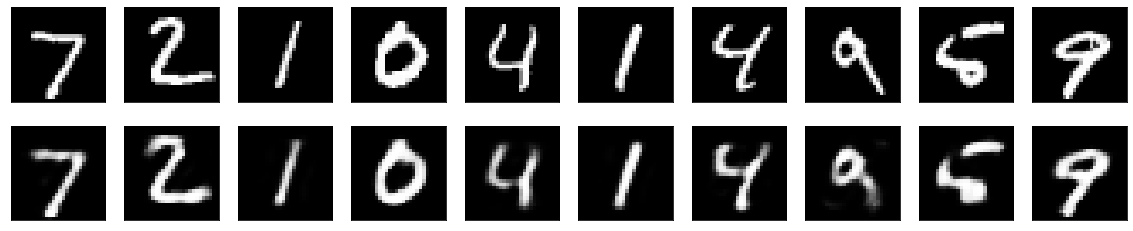

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
